In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *

This notebook explores the data imputation use case.

In [3]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# Randomly replace 20% of the Age column with NaN values
data = df.copy()
df_nan = df.sample(frac=0.3, random_state=42)
data.loc[df.index.isin(df_nan.index),'Age'] = np.nan

In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50.0,1
1,1,85,66,29,0,26.6,0.351,31.0,0
2,8,183,64,0,0,23.3,0.672,NaN,1
3,1,89,66,23,94,28.1,0.167,21.0,0
4,0,137,40,35,168,43.1,2.288,33.0,1


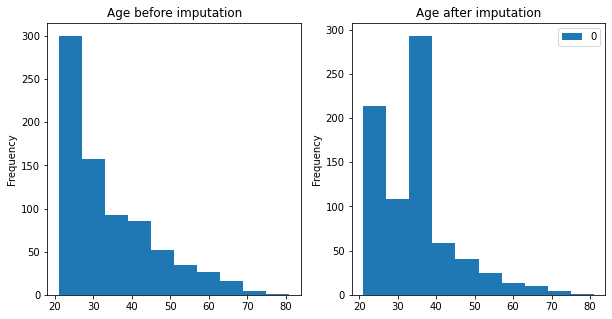

MAE imputation: 2.89453125
8.73668896216081


In [6]:
# Impute missing values using SimpleImputer in sklearn
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_imputed = imp_mean.fit_transform(data['Age'].values.reshape(-1, 1))
data_imputed = np.round(data_imputed)

# Compare the distribution of Age before and after imputation
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
df['Age'].plot(kind='hist', ax=ax1, title='Age before imputation')
ax2 = fig.add_subplot(122)
pd.DataFrame(data_imputed).plot(kind='hist', ax=ax2, title='Age after imputation')
plt.show()

y_true = df['Age'].values
y_pred = data_imputed.flatten()
print('MAE imputation:', mean_absolute_error(y_true, y_pred))
evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_relative_error()*100)

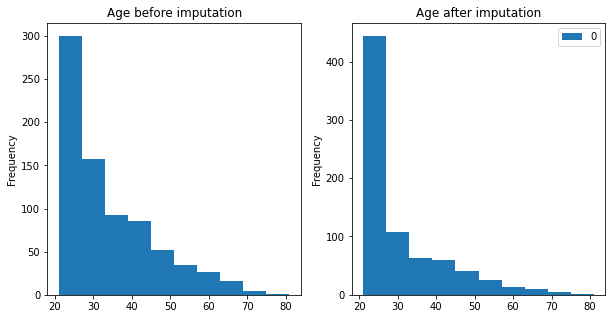

MAE imputation: 3.5247395833333335
8.381305780774468


In [23]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imputed = imp_mean.fit_transform(data['Age'].values.reshape(-1, 1))
data_imputed = np.round(data_imputed)

# Compare the distribution of Age before and after imputation
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
df['Age'].plot(kind='hist', ax=ax1, title='Age before imputation')
ax2 = fig.add_subplot(122)
pd.DataFrame(data_imputed).plot(kind='hist', ax=ax2, title='Age after imputation')
plt.show()

y_true = df['Age'].values
y_pred = data_imputed.flatten()
print('MAE imputation:', mean_absolute_error(y_true, y_pred))
evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_relative_error()*100)

In [19]:
data1 = data.copy()
data1['Age'] = data_imputed
data1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50.0,1
1,1,85,66,29,0,26.6,0.351,31.0,0
2,8,183,64,0,0,23.3,0.672,33.0,1
3,1,89,66,23,94,28.1,0.167,21.0,0
4,0,137,40,35,168,43.1,2.288,33.0,1


### Test it out

In [6]:
# load json data from a file
import json
import ast
f = open(os.path.join(ppath, 'scratch/age_partitions.json'), "r")
data = json.load(f)
f.close()
binnings = list(eval(data))

In [10]:
binnings[0]

{'bins': [0, 19, 45, 65, 85, 100],
 'labels': ['0-18', '19-44', '45-64', '65-84', '85-100'],
 'method': 'gold-standard',
 'gpt': 0.0,
 'l2_norm': 0.0,
 'spearman': 0.9999999999999999,
 'anova': 20.78361285152752}

In [7]:
# Randomly replace 20% of the Age column with NaN values
data = df.copy()
data['Age.gt'] = data['Age']
df_nan = df.sample(frac=0.3, random_state=42)
data.loc[df.index.isin(df_nan.index),'Age'] = np.nan

In [23]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age.gt
0,6,148,72,35,0,33.6,0.627,50.0,1,50
1,1,85,66,29,0,26.6,0.351,31.0,0,31
2,8,183,64,0,0,23.3,0.672,NaN,1,32
3,1,89,66,23,94,28.1,0.167,21.0,0,21
4,0,137,40,35,168,43.1,2.288,33.0,1,33
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,NaN,0,63
764,2,122,70,27,0,36.8,0.340,NaN,0,27
765,5,121,72,23,112,26.2,0.245,30.0,0,30
766,1,126,60,0,0,30.1,0.349,47.0,1,47


In [24]:
len(data[data['Age'].isnull()])

230

In [9]:
data = data.drop(columns=['Glucose', 'BMI'])
data['DiabetesPedigreeFunction.binned'] = pd.cut(data['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
data['DiabetesPedigreeFunction.binned'] = data['DiabetesPedigreeFunction.binned'].astype('float64')
data['Pregnancies.binned'] = pd.cut(data['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
data['Pregnancies.binned'] = data['Pregnancies.binned'].astype('int64')
data['Insulin.binned'] = pd.cut(data['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
data['Insulin.binned'] = data['Insulin.binned'].astype('int64')
data['BloodPressure.binned'] = pd.cut(data['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
data['BloodPressure.binned'] = data['BloodPressure.binned'].astype('int64')
data['SkinThickness.binned'] = pd.cut(data['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
data['SkinThickness.binned'] = data['SkinThickness.binned'].astype('int64')

In [72]:
tree_depth = 5
col = 'Age'
outs = []

for i in binnings:

    data_i = data.copy()
    #data_i[col + '.binned'] = pd.cut(data_i[col], bins=i['bins'], labels=i['bins'][1:])
    #data_i[col + '.binned'] = data_i[col + '.binned'].astype('float64')
    imputer = KNNImputer(n_neighbors=len(i['bins'])-1)
    data_imputed = imputer.fit_transform(data_i[col].values.reshape(-1, 1))
    data_imputed = np.round(data_imputed)
    data_i['Age.imputed'] = data_imputed
    data_i[col + '.final'] = pd.cut(data_i[col+'.imputed'], bins=i['bins'], labels=i['bins'][1:])
    data_i[col + '.final'] = data_i[col + '.final'].astype('float64')

    if len(data_i[data_i[col + '.final'].isnull()]) > 200:
        print(f"Skipping {i['bins']}")
        continue
    #data_i['Age.final'] = data_i['Age.final'].fillna(-1)
    value_final = np.array(data_i['Age.final'].values)
    value_final[np.isnan(value_final)] = -1

    # Evaluate data imputation
    data_i['Age.gt'] = pd.cut(data_i['Age.gt'], bins=i['bins'], labels=i['bins'][1:])
    data_i['Age.gt'] = data_i['Age.gt'].astype('float64')
    value_gt = np.array(data_i['Age.gt'].values)
    value_gt[np.isnan(value_gt)] = -1
    #data_i['Age.gt'] = data_i['Age.gt'].fillna(-1)
    #data_i = data_i.dropna(subset=['Age.final', 'Age.gt'])
    impute_accuracy = accuracy_score(value_gt, value_final)

    data_i = data_i.dropna(subset=['Age.final'])
    X = data_i[['Pregnancies.binned', 'Insulin.binned', 'Age.final',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
    y = data_i['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    #print(X_train[X_train.isna().any(axis=1)])
    #print(y_train[y_train.isna().any()])
    try: 
        clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    except Exception as e: 
        print("Error:", e)
        #print(X_train[X_train.isna().any(axis=1)])
        print("Strategy:", i)
        #break
    model_accuracy = accuracy_score(y_test, y_pred)
    print(f"{i['bins']}:", model_accuracy, 1-i['gpt'], impute_accuracy)
    outs.append({'bins': i['bins'], 'model_accuracy': model_accuracy, 'gpt': 1-i['gpt'], 'impute_accuracy': impute_accuracy})
    #print(f"{i['bins']}:", model_accuracy, i['gpt'])
    

[0, 19, 45, 65, 85, 100]: 0.6688311688311688 1.0 0.9518229166666666
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]: 0.6753246753246753 0.0 0.7135416666666666
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]: 0.6688311688311688 0.8 0.73046875
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 0.6558441558441559 0.8 0.76171875
[0, 20, 40, 60, 80, 100]: 0.6298701298701299 0.9 0.9231770833333334
[0, 25, 50, 75, 100]: 0.6428571428571429 0.7 0.86328125
[0, 30, 60, 90]: 0.6558441558441559 0.4 0.8268229166666666
[0, 15, 25, 65, 101]: 0.6493506493506493 0.7 0.8984375
[0, 3, 40, 60, 101]: 0.6298701298701299 0.30000000000000004 0.9231770833333334
[0, 10, 30, 60, 80, 101]: 0.6558441558441559 0.7 0.8268229166666666
[0.0, 29.0, 59.0]: 0.66 0.19999999999999996 0.8307291666666666
[21.0, 30.0, 59.0]: 0.723404255319149 0.0

In [33]:
len(outs)

28

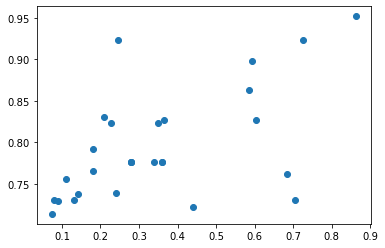

In [73]:
alpha = 0.8
# normalize model accuracy and impute accuracy
model_acc = [i['model_accuracy'] for i in outs]
impute_acc = [i['impute_accuracy'] for i in outs]
x = [alpha * i['gpt'] + (1-alpha) * ((i['model_accuracy']-min(model_acc))/(max(model_acc) - min(model_acc))) for i in outs]
#y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
y = [i['impute_accuracy'] for i in outs]
plt.scatter(x, y)
plt.show()

In [53]:
for i in range(len(outs)):
    #plt.text(x[i], y[i], str(outs[i]['bins']))
    print(outs[i]['bins'], x[i], y[i])

[0, 19, 45, 65, 85, 100] 0.5232637534139676 1.0
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100] 0.2576472883339835 0.0
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100] 0.4632637534139676 0.07103825136612038
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 0.3944966835739369 0.20218579234972694
[0, 20, 40, 60, 80, 100] 0.28696254389387443 0.8797814207650276
[0, 25, 50, 75, 100] 0.29572961373390566 0.6284153005464482
[0, 30, 60, 90] 0.2744966835739369 0.47540983606557374
[0, 15, 25, 65, 101] 0.330113148653921 0.7759562841530057
[0, 3, 40, 60, 101] 0.10696254389387441 0.8797814207650276
[0, 10, 30, 60, 80, 101] 0.36449668357393694 0.47540983606557374
[0.0, 29.0, 59.0] 0.23650214592274676 0.4918032786885246
[21.0, 30.0, 59.0] 0.5422317596566526 0.45901639344262296
[0.0, 25.0, 35.0, 59.0] 0.13060085836909857 0

### missing -> binning -> imputation

In [10]:
tree_depth = 5
col = 'Age'
outs = []

for i in binnings:

    data_i = data.copy()
    data_i[col + '.binned'] = pd.cut(data_i[col], bins=i['bins'], labels=i['bins'][1:])
    #data_i[col + '.binned'] = data_i[col + '.binned'].astype('float64')

    imputer = KNNImputer(n_neighbors=len(i['bins'])-1)
    data_imputed = imputer.fit_transform(data_i[col + '.binned'].values.reshape(-1, 1))
    data_imputed = np.round(data_imputed)
    data_i['Age.imputed'] = data_imputed
    data_i[col + '.final'] = pd.cut(data_i[col+'.imputed'], bins=i['bins'], labels=i['bins'][1:])
    data_i[col + '.final'] = data_i[col + '.final'].astype('float64')

    if len(data_i[data_i[col + '.final'].isnull()]) > 200:
        print(f"Skipping {i['bins']}")
        continue
    #data_i['Age.final'] = data_i['Age.final'].fillna(-1)
    value_final = np.array(data_i['Age.final'].values)
    value_final[np.isnan(value_final)] = -1

    # Evaluate data imputation
    data_i['Age.gt'] = pd.cut(data_i['Age.gt'], bins=i['bins'], labels=i['bins'][1:])
    data_i['Age.gt'] = data_i['Age.gt'].astype('float64')
    value_gt = np.array(data_i['Age.gt'].values)
    value_gt[np.isnan(value_gt)] = -1
    #data_i['Age.gt'] = data_i['Age.gt'].fillna(-1)
    #data_i = data_i.dropna(subset=['Age.final', 'Age.gt'])
    impute_accuracy = accuracy_score(value_gt, value_final)

    data_i = data_i.dropna(subset=['Age.final'])
    X = data_i[['Pregnancies.binned', 'Insulin.binned', 'Age.final',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
    y = data_i['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    #print(X_train[X_train.isna().any(axis=1)])
    #print(y_train[y_train.isna().any()])
    try: 
        clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    except Exception as e: 
        print("Error:", e)
        #print(X_train[X_train.isna().any(axis=1)])
        print("Strategy:", i)
        #break
    model_accuracy = accuracy_score(y_test, y_pred)
    print(f"{i['bins']}:", model_accuracy, 1-i['gpt'], impute_accuracy)
    outs.append({'bins': i['bins'], 'model_accuracy': model_accuracy, 'gpt': 1-i['gpt'], 'impute_accuracy': impute_accuracy})
    #print(f"{i['bins']}:", model_accuracy, i['gpt'])
    

[0, 19, 45, 65, 85, 100]: 0.6883116883116883 1.0 0.7473958333333334
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]: 0.6753246753246753 0.0 0.7135416666666666
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]: 0.6688311688311688 0.8 0.73046875
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 0.6558441558441559 0.8 0.76171875
[0, 20, 40, 60, 80, 100]: 0.6363636363636364 0.9 0.765625
[0, 25, 50, 75, 100]: 0.6428571428571429 0.7 0.86328125
[0, 30, 60, 90]: 0.6558441558441559 0.4 0.8268229166666666
[0, 15, 25, 65, 101]: 0.6493506493506493 0.7 0.8984375
[0, 3, 40, 60, 101]: 0.6363636363636364 0.30000000000000004 0.765625
[0, 10, 30, 60, 80, 101]: 0.6558441558441559 0.7 0.8268229166666666
[0.0, 29.0, 59.0]: 0.6493506493506493 0.19999999999999996 0.8046875
[21.0, 30.0, 59.0]: 0.6428571428571429 0.099999999999999

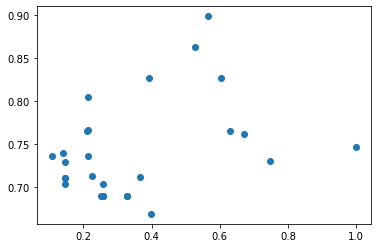

In [84]:
alpha = 0.7
# normalize model accuracy and impute accuracy
model_acc = [i['model_accuracy'] for i in outs]
impute_acc = [i['impute_accuracy'] for i in outs]
x = [alpha * i['gpt'] + (1-alpha) * ((i['model_accuracy']-min(model_acc))/(max(model_acc) - min(model_acc))) for i in outs]
#y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
y = [i['impute_accuracy'] for i in outs]
plt.scatter(x, y)
plt.show()

In [103]:
top_k = 3
y2 = []
for alpha in np.arange(0, 1, 0.1):
    # normalize model accuracy and impute accuracy
    model_acc = [i['model_accuracy'] for i in outs]
    impute_acc = [i['impute_accuracy'] for i in outs]
    x = [alpha * i['gpt'] + (1-alpha) * ((i['model_accuracy']-min(model_acc))/(max(model_acc) - min(model_acc))) for i in outs]
    #y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
    y = [i['impute_accuracy'] for i in outs]
    z = []
    for i in range(len(outs)):
        #plt.text(x[i], y[i], str(outs[i]['bins']))
        z.append((outs[i]['bins'], x[i], y[i]))
        #print(outs[i]['bins'], x[i], y[i])
    sorted(z, key=lambda x: x[1], reverse=True)
    # get mean y[i] for top k
    mean_y = np.mean([i[2] for i in sorted(z, key=lambda x: x[1], reverse=True)[:top_k]])
    y2.append(mean_y)
    print("alpha:", alpha, "mean_y:", mean_y)

alpha: 0.0 mean_y: 0.7243923611111112
alpha: 0.1 mean_y: 0.7243923611111112
alpha: 0.2 mean_y: 0.7300347222222223
alpha: 0.30000000000000004 mean_y: 0.7300347222222223
alpha: 0.4 mean_y: 0.7465277777777778
alpha: 0.5 mean_y: 0.7465277777777778
alpha: 0.6000000000000001 mean_y: 0.7465277777777778
alpha: 0.7000000000000001 mean_y: 0.7465277777777778
alpha: 0.8 mean_y: 0.7478298611111112
alpha: 0.9 mean_y: 0.7478298611111112


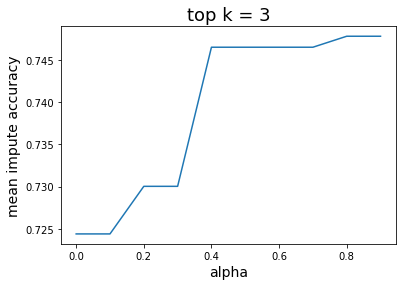

In [104]:
plt.plot(np.arange(0, 1, 0.1), y2)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('mean impute accuracy', fontsize=14)
plt.title(f'top k = {top_k}', fontsize=18)
plt.show()

In [122]:
top_k = 5
y2 = []
for alpha in np.arange(0, 1.1, 0.1):
    # normalize model accuracy and impute accuracy
    model_acc = [i['model_accuracy'] for i in outs]
    impute_acc = [i['impute_accuracy'] for i in outs]
    x = [alpha * i['gpt'] + (1-alpha) * ((i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc))) for i in outs]
    #y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
    y = [i['model_accuracy'] for i in outs]
    z = []
    for i in range(len(outs)):
        #plt.text(x[i], y[i], str(outs[i]['bins']))
        z.append((outs[i]['bins'], x[i], y[i]))
        #print(outs[i]['bins'], x[i], y[i])
    sorted(z, key=lambda x: x[1], reverse=True)
    # get mean y[i] for top k
    mean_y = np.mean([i[2] for i in sorted(z, key=lambda x: x[1], reverse=True)[:top_k]])
    y2.append(mean_y)
    print("alpha:", alpha, "mean_y:", mean_y)

alpha: 0.0 mean_y: 0.6506493506493507
alpha: 0.1 mean_y: 0.6506493506493507
alpha: 0.2 mean_y: 0.648051948051948
alpha: 0.30000000000000004 mean_y: 0.648051948051948
alpha: 0.4 mean_y: 0.6545454545454545
alpha: 0.5 mean_y: 0.6545454545454545
alpha: 0.6000000000000001 mean_y: 0.6545454545454545
alpha: 0.7000000000000001 mean_y: 0.6545454545454545
alpha: 0.8 mean_y: 0.6545454545454545
alpha: 0.9 mean_y: 0.6597402597402597
alpha: 1.0 mean_y: 0.6584415584415584


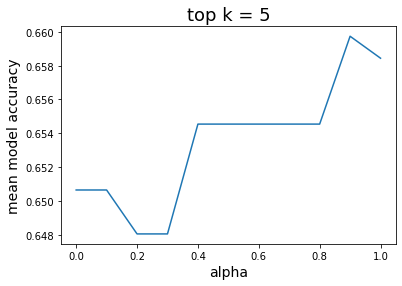

In [123]:
plt.plot(np.arange(0, 1.1, 0.1), y2)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('mean model accuracy', fontsize=14)
plt.title(f'top k = {top_k}', fontsize=18)
plt.show()

### pareto curve

In [110]:
datapoints=np.random.rand(2, 50)
datapoints

array([[0.71691644, 0.59124215, 0.42349582, 0.5939245 , 0.46487134,
        0.62940706, 0.97822296, 0.25388094, 0.15099489, 0.25696939,
        0.62759761, 0.95835526, 0.87314923, 0.48423491, 0.74931096,
        0.54714618, 0.49264806, 0.15866351, 0.74022519, 0.11562332,
        0.37357008, 0.09661767, 0.87647029, 0.28011315, 0.86945105,
        0.04253538, 0.32107033, 0.77506231, 0.11534431, 0.80461076,
        0.86028884, 0.43529135, 0.07122995, 0.57248749, 0.72864558,
        0.24989706, 0.09370352, 0.93149974, 0.66215723, 0.4870712 ,
        0.16350835, 0.54363033, 0.21574577, 0.04054469, 0.5443845 ,
        0.90745565, 0.90212045, 0.21386356, 0.84574628, 0.31890832],
       [0.15699532, 0.99267228, 0.95677354, 0.36654559, 0.03476378,
        0.62153622, 0.80306497, 0.48474144, 0.94582107, 0.12161229,
        0.95510631, 0.71502654, 0.49514553, 0.98142254, 0.24356971,
        0.1677284 , 0.63067456, 0.62808609, 0.59862001, 0.47396508,
        0.07476063, 0.7345975 , 0.19084403, 0.0

In [13]:
datapoints0 = [x['gpt'] for x in outs]
datapoints1 = [x['model_accuracy'] for x in outs]
datapoints2 = [x['impute_accuracy'] for x in outs]
datapoints = np.array([datapoints0[0:], datapoints2[0:]])
datapoints

array([[1.        , 0.        , 0.8       , 0.8       , 0.9       ,
        0.7       , 0.4       , 0.7       , 0.3       , 0.7       ,
        0.2       , 0.1       , 0.2       , 0.2       , 0.2       ,
        0.2       , 0.1       , 0.1       , 0.2       , 0.2       ,
        0.1       , 0.2       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.3       ],
       [0.74739583, 0.71354167, 0.73046875, 0.76171875, 0.765625  ,
        0.86328125, 0.82682292, 0.8984375 , 0.765625  , 0.82682292,
        0.8046875 , 0.73697917, 0.76692708, 0.73697917, 0.73958333,
        0.69010417, 0.72916667, 0.69010417, 0.71223958, 0.69010417,
        0.7109375 , 0.69010417, 0.7109375 , 0.69010417, 0.70442708,
        0.69010417, 0.70442708, 0.66927083]])

In [14]:
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, datapoints.shape[1]):
    w=oapackage.doubleVector( (datapoints[0,ii], datapoints[1,ii]))
    pareto.addvalue(w, ii)

pareto.show(verbose=1)

Pareto: 3 optimal values, 3 objects


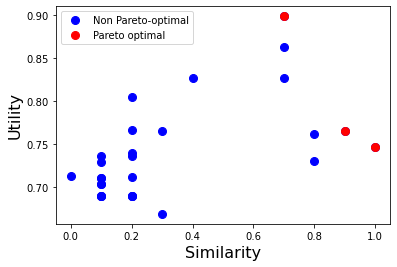

In [15]:
lst=pareto.allindices() # the indices of the Pareto optimal designs

optimal_datapoints=datapoints[:,lst]

h=plt.plot(datapoints[0,:], datapoints[1,:], '.b', markersize=16, label='Non Pareto-optimal')
hp=plt.plot(optimal_datapoints[0,:], optimal_datapoints[1,:], '.r', markersize=16, label='Pareto optimal')
plt.xlabel('Similarity', fontsize=16)
plt.ylabel('Utility', fontsize=16)
#plt.xticks([])
#plt.yticks([])
_=plt.legend(loc=0, numpoints=1)